In [1]:
# CNN의 각 층에서 중요하게 생각하는 층 시각화하기(XAI와도 관련이 있음)
# --> 경사상승법을 통해 각 층을 지나며 이미지의 특징이 어떻게 변화하는지 체크

from __future__ import print_function
from keras.preprocessing.image import load_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications import inception_v3
from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
from PIL import Image


import sys
import time
import scipy
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import functools
import cProfile

#tf.compat.v1.disable_eager_execution()
sys.setrecursionlimit(50000)


In [2]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [3]:
# input image
input_img = model.input

# input layer_name
layer_name = 'block5_conv1'
img_width, img_height = 128, 128

# 각 층의 이름을 딕셔너리에 등록
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [4]:
# 텐서를 이미지로 변환

def deprocess_image(x):

  # 텐서를 평균0, 표준편차0.1이 되도록 정규화
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  # 구간을 [0,1]로 클리핑
  x += 0.5
  x = np.clip(x, 0, 1)

  # RGB 배열로 
  x *= 255
  if K.image_data_format() == 'th':
      x = x.transpose((1, 2, 0))
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [5]:
kept_filters = []

for filter_index in range(0, 10):
    # we only scan through the first 200 filters,
    # but there are more (512)
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    
    # The img_size variable is computed this way
    # The dim_ordering can either be “tf” or “th”. It tells 
    # Keras whether to use Theano or TensorFlow dimension ordering for inputs/kernels/ouputs.
    loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
Current loss value: 13.009565
Current loss value: 27.108536
Current loss value: 48.941956
Current loss value: 72.74323
Current loss value: 94.40565
Current loss value: 112.1188
Current loss value: 130.68141
Current loss value: 152.55157
Current loss value: 170.3421
Current loss value: 193.90224
Current loss value: 209.53755
Current loss value: 232.12437
Current loss value: 251.85541
Current loss value: 276.10742
Current loss value: 295.33026
Current loss value: 320.62817
Current loss value: 339.97116
Current loss value: 364.20917
Current loss value: 386.5836
Current loss value: 410.5727
Filter 0 processed in 15s
Processing filter 1
Current loss value: 0.0
Filter 1 processed in 0s
Processing filter 2
Current loss value: 8.119112
Current loss value: 22.280506
Current loss value: 45.919876
Current loss value: 76.43855
Current loss value: 106.9594
Current loss value: 137.35153
Current loss value: 168.7756
Current loss value: 199.2758
Current loss value: 231.33328
Curren

In [6]:
from keras.preprocessing.image import save_img

# the largest possible square will be used
n = int(np.floor(np.sqrt(len(kept_filters))))

# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3), dtype='uint8')

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
save_img('vgg_{0:}_{1:}x{1:}.png'.format(layer_name, n), stitched_filters)

# 딥드림 알고리즘 실습 
* 옥타브를 거치며 이미지를 축소하고, 이미지를 확대하며 딥드림 알고리즘을 적용시켜 몽환적인 이미지 연출
* 각 층별로 어떤 기능을 하는지, XAI의 역할까지도 기대 가능

In [7]:
K.set_learning_phase(0)    # 모델을 추론모드로 설정(학습X)


# 인셉션 모델 로드
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
print(model.summary())

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


87924736/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)           

In [8]:
# 각 층의 영향력을 딕셔너리 형태로 설정
# 어떤 층을 선택했는지와 그 층이 전체 손실값에 미치는 영향력에 따라 딥드림의 결과로 출력되는 이미지는 큰 영향을 받음
# * 앞쪽층은 모서리/기하학적 패턴을 추가하는데 사용되며 뒤쪽층은 개/고양이/새 등의 일부 같은 몽환적인 패턴을 추가한다.

layer_contributions = {
    'mixed2' : 0.2,
    'mixed3' : 3.,
    'mixed4' : 2.,
    'mixed5' : 1.5,
}

layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)  # 각 층의 영향력을 loss 변수에 더해 손실을 계산할 것

for layer_name in layer_contributions:
  coeff = layer_contributions[layer_name]
  activation = layer_dict[layer_name].output
  scaling = K.prod(K.cast(K.shape(activation), 'float32'))

  loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [9]:
# 손실 계산

dream = model.input    # 생성된 이미지를 저장하는 텐서
grads = K.gradients(loss, dream)[0]  # 손실에 대한 생성 이미지의 경사를 계산

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)   # 경사를 정규화
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs) 

def eval_loss_and_grads(x):
  outs = fetch_loss_and_grads([x])
  loss_value = outs[0]
  grad_values = outs[1]
  return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
  for i in range(iterations):
    loss_value, grad_values = eval_loss_and_grads(x)
    if max_loss is not None and loss_value > max_loss:
      break
    print(i, ' 번째 반복의 손실값 : ', loss_value)
  
  return x

In [10]:
# 이미지 전처리 및 과정 출력함수

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
            1)
    return scipy.ndimage.zoom(img, factors, order=1)
    
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
# 딥드림 알고리즘 구현 순서
# 1. 입력 이미지 읽어들임
# 2. 배율 수 정의
# 3. 입력 이미지를 설정된 배율 중 가장 작은 크기로 축소
# 4. 가장 작은 배율로 시작해 다음을 반복하며 한 단계씩 이미지를 확대
#   - 경사 상승법 수행  --> 다음 배율로 이미지 확대  --> 이미지 확대로 손실된 세부 묘사 재주입
# 5. 이미지가 원래 크기로 돌아오면 처리를 종료

step = 0.1   # 경사 상승법의 이미지 수정 크기
num_octave = 5  # 경사 상승법을 수행할 배율 수
octave_scale = 1.8  # 배율 간의 차이
iterations = 20   # 경사 상승법의 반복 횟수
max_loss = 10.

base_img_path = '/content/drive/MyDrive/com_vision_study/data/GoldenGateBridge.jpg'
img = preprocess_image(base_img_path)
original_shape = img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
  shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])

  successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:

  print('이미지 변형 중', shape)
  
  img = resize_img(img, shape)
  img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
  upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
  same_size_original = resize_img(original_img, shape)
  lost_detail = same_size_original - upscaled_shrunk_original_img
  img += lost_detail
  shrunk_original_img = resize_img(original_img, shape)

  phil_img = deprocess_image(np.copy(img))
  save_img(f'{str(shape)}.png', phil_img)

final_img = deprocess_image(np.copy(img))
save_img('final_dream.png', final_img)

이미지 변형 중 (50, 76)
0  번째 반복의 손실값 :  0.0
1  번째 반복의 손실값 :  0.0
2  번째 반복의 손실값 :  0.0
3  번째 반복의 손실값 :  0.0
4  번째 반복의 손실값 :  0.0
5  번째 반복의 손실값 :  0.0
6  번째 반복의 손실값 :  0.0
7  번째 반복의 손실값 :  0.0
8  번째 반복의 손실값 :  0.0
9  번째 반복의 손실값 :  0.0
10  번째 반복의 손실값 :  0.0
11  번째 반복의 손실값 :  0.0
12  번째 반복의 손실값 :  0.0
13  번째 반복의 손실값 :  0.0
14  번째 반복의 손실값 :  0.0
15  번째 반복의 손실값 :  0.0
16  번째 반복의 손실값 :  0.0
17  번째 반복의 손실값 :  0.0
18  번째 반복의 손실값 :  0.0
19  번째 반복의 손실값 :  0.0
이미지 변형 중 (91, 137)
0  번째 반복의 손실값 :  0.045296896
1  번째 반복의 손실값 :  0.045296896
2  번째 반복의 손실값 :  0.045296896
3  번째 반복의 손실값 :  0.045296896
4  번째 반복의 손실값 :  0.045296896
5  번째 반복의 손실값 :  0.045296896
6  번째 반복의 손실값 :  0.045296896
7  번째 반복의 손실값 :  0.045296896
8  번째 반복의 손실값 :  0.045296896
9  번째 반복의 손실값 :  0.045296896
10  번째 반복의 손실값 :  0.045296896
11  번째 반복의 손실값 :  0.045296896
12  번째 반복의 손실값 :  0.045296896
13  번째 반복의 손실값 :  0.045296896
14  번째 반복의 손실값 :  0.045296896
15  번째 반복의 손실값 :  0.045296896
16  번째 반복의 손실값 :  0.045296896
17  번째 반복의 손실값 :  0.045296896
18 

# 신경 스타일 전이 알고리즘 실습
* 특정 이미지(스타일 이미지)의 화풍을 다른 이미지(콘텐츠 이지)로 옮겨 적용
* 콘텐츠 손실, 스타일 손실, 노이즈 손실함수를 만들고 각 값이 최소화 되도록 학습시킨다

In [32]:
# 1) 콘텐츠 손실 : 두 이미지가 포함된 대상과 그 위치가 서로 차이나는 정도를 측정
#  콘텐츠 이미지와 통합 이미지에 대한 출력의 평균 제곱오차 측정 --> 이 오차를 최소화하게 한 다음 --> 통합이미지에 대상을 더 추가해서 콘텐츠 이미지와 비슷한 이미지를 만들게 함


# 이미지 로드 및 visualize
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
print("Eager execution: {}".format(tf.executing_eagerly()))



content_path = '/content/drive/MyDrive/com_vision_study/data/two-dolphins.jpg'
style_path = '/content/drive/MyDrive/com_vision_study/data/picasso.jpg'

def load_img(path):
  max_dim = 512
  img = Image.open(path)
  long = max(img.size)
  scale = max_dim / long
  img = img.resize((round(img.size[0] * scale ), round(img.size[1] * scale)), Image.ANTIALIAS)

  img = kp_image.img_to_array(img)

  img = np.expand_dims(img, axis=0) # batch 차원 맨 앞에 추가하기
  return img


def imshow(img, title=None):
  # batch 차원 제거
  out = np.squeeze(img, axis=0)
  # 정규화
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  
  plt.imshow(out)

Eager execution: True


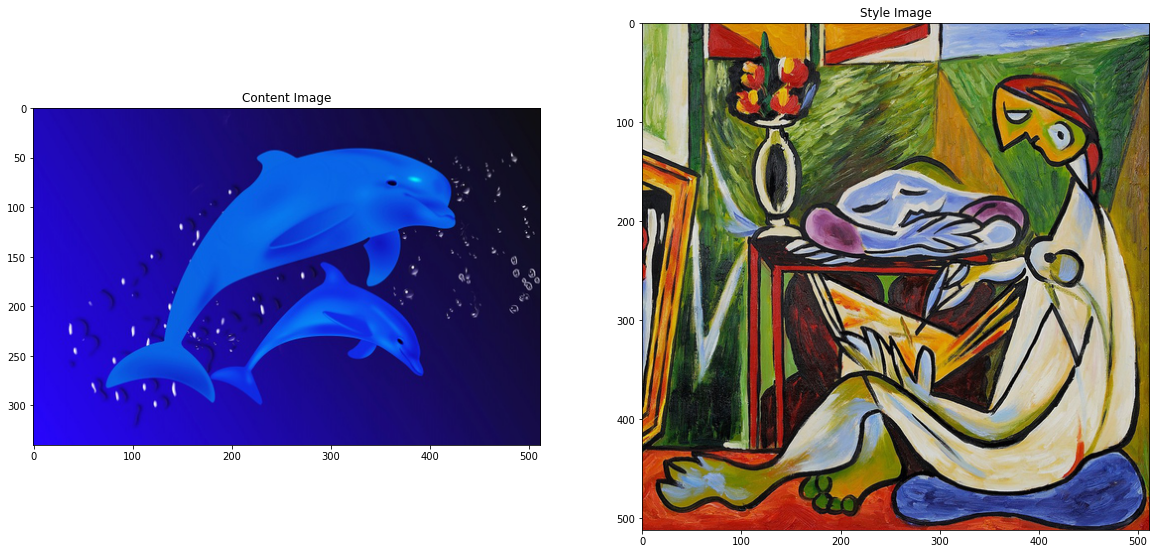

In [33]:
plt.figure(figsize=(20,20))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1,2,1)
imshow(content, 'Content Image')

plt.subplot(1,2,2)
imshow(style, 'Style Image')
plt.show()

In [34]:
# 합성곱 층으로 VGG-19 사용 
# process & deprocess 함수 

def load_and_process_img(path):
  img = load_img(path)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img


def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0) # 배치 차원 제거
  
  assert len(x.shape) == 3

  if len(x.shape) != 3:
    raise ValueError('Invalid input to deprocessing image')
  
  # vgg19.preprocess_input 변환과정 이전으로 이미지 돌리기
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [20]:
# vgg19층 중 content layer를 담당할 층과 
# style layer를 담당할 층 정의
# 콘텐츠 손실은 두 이미지의 대상/위치(고수준 특징)만을 파악하면 되므로 마지막 한 층에서 수행하는 경우가 많음(간단)
# 스타일 손실은 저수준/중수준/고수준 특징의 여러 배율에서 화풍을 추출해야 하므로 신경망의 여러층을 선택해야 함

content_layers = ['block5_conv2'] 


style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [21]:
# 모델 정의
def get_model():
  
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable=False

  # style_output, content_output을 통합한 model_outputs를 출력
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs

  return models.Model(vgg.input, model_outputs)

In [22]:
# 콘텐츠 손실, 스타일 손실 정의


def content_loss(content_image, combined_image):
  return tf.reduce_mean(tf.square(content_image, combined_image))  # 콘텐츠 이미지와 통합 이미지간 평균제곱오차 계산


# 스타일 손실을 콘텐츠 손실과 달리 복잡...
# 콘텐츠 이미지의 물체 배치에 대한 정보는 배제하고 스타일 이미지의 질감/패턴 등만을 추출 
# gram_matrix --> 합성곱 신경망 여러 층의 활성화도 간의 상관을 계산해 합성곱신경망의 여러 층에서 질감/화풍을 포착하는 손실함수 계산
def gram_matrix(input_tensor):
  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.reshape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  return gram / tf.cast(n, tf.float32)


def style_loss(style_image, combined_image):

  height, width, channels = style_image.get_shape().as_list()
  gram_style = gram_matrix(style_image)

  return tf.reduce_mean(tf.square(gram_style - combined_image))

In [23]:
# 스타일 전이 적용
# vgg19의 중간층들에서 스타일/콘텐츠 이미지가 어떻게 추출/변형되는지 확인

def get_feature_representations(model, content_path, style_path):

  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)

  # 모델 거친 후 outputs 획득
  style_outputs = model(style_image)
  content_outputs = model(content_image)

  # style_features & content_features representation 획득
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

  return style_features, content_features

In [24]:
# computing loss and gradients
# 가중치를 부여한 콘텐츠 손실, 스타일 손실 및 총 분산 손실을 계산

def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

  style_weight, content_weight = loss_weights

  model_outputs = model(init_image)

  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]

  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score

def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [12]:
# optimization loop

import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

In [35]:
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [36]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [37]:
# Feature map extraction for style transfer
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [38]:
def get_model():
  """ Creates our model with access to intermediate layers. 
  
  This function will load the VGG19 model and access the intermediate layers. 
  These layers will then be used to create a new model that will take input image
  and return the outputs from these intermediate layers from the VGG model. 
  
  Returns:
    returns a keras model that takes image inputs and outputs the style and 
      content intermediate layers. 
  """
  # Load our model. We load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  # Get output layers corresponding to style and content layers 
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs + content_outputs
  # Build model 
  return models.Model(vgg.input, model_outputs)

In [39]:
def get_content_loss(base_content, target):
  return tf.reduce_mean(tf.square(base_content - target))

In [40]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
  """Expects two images of dimension h, w, c"""
  # height, width, num filters of each layer
  # We scale the loss at a given layer by the size of the feature map and the number of filters
  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)
  
  return tf.reduce_mean(tf.square(gram_style - gram_target))

In [41]:
def get_feature_representations(model, content_path, style_path):
  """Helper function to compute our content and style feature representations.

  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
  # Load our images in 
  content_image = load_and_process_img(content_path)
  style_image = load_and_process_img(style_path)
  
  # batch compute content and style features
  style_outputs = model(style_image)
  content_outputs = model(content_image)
  
  
  # Get the style and content feature representations from our model  
  style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
  content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
  return style_features, content_features


In [42]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
  """This function will compute the loss total loss.
  
  Arguments:
    model: The model that will give us access to the intermediate layers
    loss_weights: The weights of each contribution of each loss function. 
      (style weight, content weight, and total variation weight)
    init_image: Our initial base image. This image is what we are updating with 
      our optimization process. We apply the gradients wrt the loss we are 
      calculating to this image.
    gram_style_features: Precomputed gram matrices corresponding to the 
      defined style layers of interest.
    content_features: Precomputed outputs from defined content layers of 
      interest.
      
  Returns:
    returns the total loss, style loss, content loss, and total variational loss
  """
  style_weight, content_weight = loss_weights
  
  # Feed our init image through our model. This will give us the content and 
  # style representations at our desired layers. Since we're using eager
  # our model is callable just like any other function!
  model_outputs = model(init_image)
  
  style_output_features = model_outputs[:num_style_layers]
  content_output_features = model_outputs[num_style_layers:]
  
  style_score = 0
  content_score = 0

  # Accumulate style losses from all layers
  # Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, style_output_features):
    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
  # Accumulate content losses from all layers 
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, content_output_features):
    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
  style_score *= style_weight
  content_score *= content_weight

  # Get total loss
  loss = style_score + content_score 
  return loss, style_score, content_score


In [43]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss


In [44]:
# optimization loop

import IPython.display

def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
      
  return best_img, best_loss 

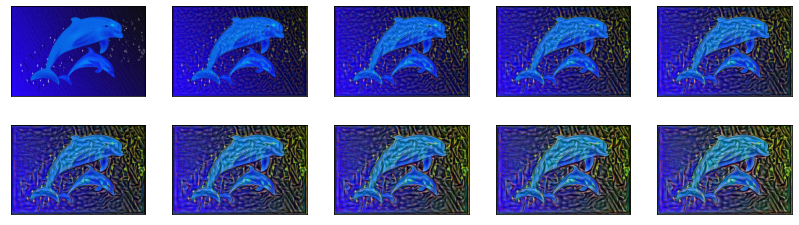

In [45]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=100,
                                     content_weight=1e3, style_weight=1e-2)

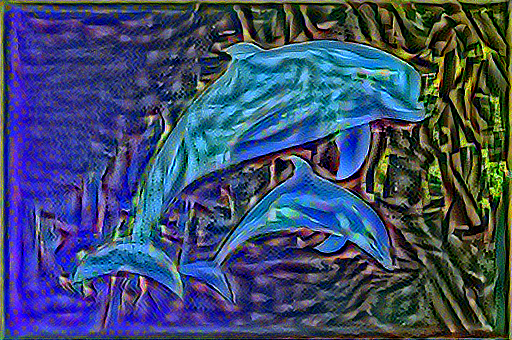

In [46]:
Image.fromarray(best)

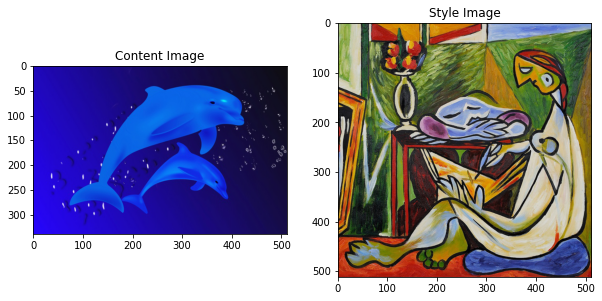

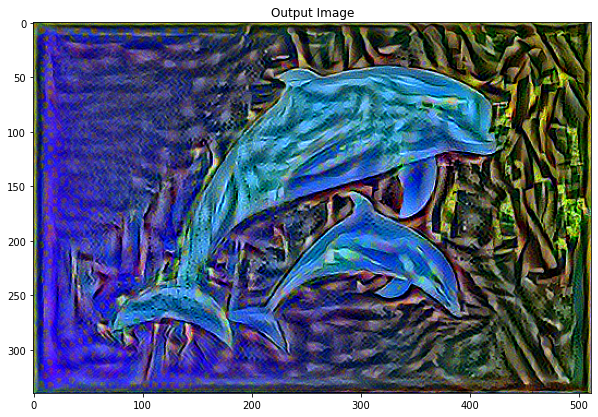

In [47]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_img(content_path) 
  style = load_img(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final: 
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()
  
show_results(best, content_path, style_path)